In [1]:
#imports
import pandas as pd
import numpy as np
import os
import folium
from folium import IFrame
import json
from folium import plugins
from scipy.ndimage import imread
import random
import copy
import vega
import vincent
import collections
from collections import Counter
from collections import defaultdict
from itertools import filterfalse
import time
import csv
import ast
import re
import base64
from PIL import Image, ImageTk

In [2]:
vincent.core.initialize_notebook()

In [4]:
json_path = r'data/map_data/world-countries.json'

world_countries = json.load(open(json_path))

map_data = folium.Map(location=[46.947456, 7.451123], tiles='Mapbox Bright', zoom_start=2)

style_function = lambda x: {'weight': '0.4',
                            'fillColor': '#FF0000' if
                                x['properties']['name']=='Switzerland' else
                                         '#34BED2'}

geojson = folium.GeoJson(
    world_countries,
    name='geojson',
    style_function=style_function,
).add_to(map_data)
popup = folium.Popup("a country")
popup.add_to(geojson)

folium.LayerControl().add_to(map_data)
map_data

In [6]:
db = pd.read_csv('cleaning_data/categories_db.csv')

In [7]:
dict_to_plot = {'products': db.Count.tolist(), 'amount': db.category_main.tolist()}

In [9]:
index_loc = range(db.shape[1])
categories = db.category_main.values.tolist()
counts = db.Count.values.tolist()
zipped = zip(categories, counts)
dic_db = dict(list(zipped))
dic_db

{'Dried fruits and nuts': 3,
 'Fruits': 6,
 'Vegetables': 6,
 'Condiments': 7,
 'Honeys': 10,
 'Oils': 14,
 'Fermented products': 19,
 'Tee and infusions': 20,
 'Baby food': 22,
 'Canned products': 24,
 'Spreads': 34,
 'Sauces': 37,
 'Frozen products': 43,
 'Alcoholic beverages': 49,
 'Confections': 78,
 'Ready meals': 101,
 'Drinks': 134,
 'Grains, beans and legumes': 135,
 'Meat, fish and egg': 163,
 'Plant based products': 194,
 'Dairy products': 337}

In [10]:
from vincent import *

bar = vincent.Bar(dic_db)
bar.axis_titles(x="", y="Quantity")
bar.height = 150 
bar.width = 300
ax = AxisProperties(labels = PropertySet(angle=ValueRef(value=45), align=ValueRef(value="left")))
bar.axes[0].properties = ax
 
bar.to_json('barplot.json')
bar

In [14]:
json_path = r'data/map_data/world-countries.json'
barplot = json.load(open(r'barplot.json'))
world_countries = json.load(open(json_path))
map_data = folium.Map(location=[46.947456, 7.451123], tiles='Mapbox Bright', zoom_start=5, max_zoom=7, min_zoom=3)

style_function = lambda x: {'weight': '0.4',
                            'fillColor': '#FF0000' if
                                x['properties']['name']=='Switzerland' else
                                         '#34BED2'}

for feature in world_countries["features"] :
    coord = copy.deepcopy(feature['geometry']['coordinates'])
    popup_text = "<b>Country name</b>: "+ copy.deepcopy(feature['properties']['name']+"<br>")
    
    if feature['properties']['name'] == 'Switzerland':
        popup = folium.Popup(popup_text, max_width=400) 
        folium.Vega(bar, height=300, width=1000).add_to(popup)
    else:
        popup = folium.Popup(popup_text)
        
    geojson = folium.GeoJson(feature,
                    style_function=style_function)
    popup.add_to(geojson)
    geojson.add_to(map_data)
map_data.save('docs/img/maps/swiss_map.html')
map_data

In [2]:
import plotly as py
import pandas as pd
import numpy as np
import plotly.tools as plotly_tools
import plotly.graph_objs as go

In order to confirm or infirm the results from our main database https://ch-fr.openfoodfacts.org/
we found official data from the swiss government.
One database is the swiss Federal Customs Adiministration https://www.gate.ezv.admin.ch/swissimpex/, which provides information on Food, Beverages and Tobacco imports from 1988 until nowadays, either yearly or monthly.
Another datasource are the official statistics from the Union suisse des Paysans https://www.sbv-usp.ch/fileadmin/sbvuspch/05_Publikationen/SES/SES_2016-93.pdf, which provides data on the food consumption of the swiss population. They also provide information on different food category, such as the amount of imports in kg and kj, and the indigenous production in percentage of consumption.
Finally, there is data from the swiss Federal Statistics Bureau https://www.bfs.admin.ch/bfs/fr/home/statistiques/catalogues-banques-donnees.html, which provides demographic data.

In [2]:
#Import of the various datasets
#swiss production in percentage of consumption
swiss_prod_percent_file = 'data/official_source_foodstuffs_food_swiss_prod_percent.xlsx'
#swiss consumption of food products in kg
swiss_conso_kg_file = 'data/official_source_foodstuffs_consumption_kg.xlsx'
swiss_prod_percent = pd.read_excel(swiss_prod_percent_file, header=0)
swiss_conso_kg = pd.read_excel(swiss_conso_kg_file, header=0)

In [3]:
#swiss total import of Agricultural products per year (1988-2018) from the Federal Customs Administration
evolution_import_db_path = 'data/imports_food_products_1988-2017.xlsx'
evolution_import_db = pd.read_excel(evolution_import_db_path, sheet_name = '01', header=5)
evolution_import_db = evolution_import_db.dropna(how='all')
evolution_import_db = evolution_import_db.dropna(axis ='columns')
evolution_import_db.index.name = 'Years'
evolution_import_db = evolution_import_db.reset_index()
evolution_import_db = evolution_import_db.astype({'Quantité (kg)': 'int64', 'Valeur (CHF)': 'int64'})

In [4]:
#swiss total import of food products (Food, Beverages and Tobacco) per year (2012-2018) from the Federal Customs Administration
evolution_import_db_path = 'data/total_import_year_foodstuffs.xlsx'
evolution_import_foodstuffs = pd.read_excel(evolution_import_db_path, sheet_name = '04.1', header=5)
evolution_import_foodstuffs = evolution_import_foodstuffs.dropna(how='all')
evolution_import_foodstuffs = evolution_import_foodstuffs.dropna(axis ='columns')
evolution_import_foodstuffs.index.name = 'Years'
evolution_import_foodstuffs = evolution_import_foodstuffs.reset_index()
evolution_import_foodstuffs = evolution_import_foodstuffs.astype({'Quantité (kg)': 'int64', 'Valeur (CHF)': 'int64'})

In [5]:
#swiss total import of food products (Food, Beverages and Tobacco) per month (2012-2018) from the Federal Customs Administration
evolution_import_db_path = 'data/total_import_month_foodstuffs.xlsx'
evolution_month_import_foodstuffs = pd.read_excel(evolution_import_db_path, sheet_name = '04.1', header=5)
evolution_month_import_foodstuffs = evolution_month_import_foodstuffs.dropna(how='all')
evolution_month_import_foodstuffs = evolution_month_import_foodstuffs.dropna(axis ='columns')
evolution_month_import_foodstuffs.index.name = 'Years'
evolution_month_import_foodstuffs = evolution_month_import_foodstuffs.reset_index()
evolution_month_import_foodstuffs = evolution_month_import_foodstuffs.astype({'Quantité (kg)': 'int64', 'Valeur (CHF)': 'int64'})

Generate for each product category a plot with the amount of consumption in kg and the percentage of indigenous production

In [61]:
#Generate for each product category a plot with the amount of consumption in kg and the percentage of indigenous production
for col in swiss_prod_percent.columns:
    trace0 = go.Bar(
        x=swiss_conso_kg.index.values,
        y=swiss_conso_kg[col].values,
        name='kg',
        marker=dict(color='#33CFA5')
    )

    trace1 = go.Bar(
        x=swiss_prod_percent.index.values,
        y=swiss_prod_percent[col].values,
        name='%',
        marker=dict(color='#F06A6A')
    )

    data = [trace0, trace1]
        
    updatemenus = list([
        dict(active = 1,
            showactive = True,
            x = 0,
            xanchor = 'left',
            y = 1.5,
            yanchor = 'top',
             buttons=list([
                 dict(label = 'Food consumption',
                      method = 'update',
                      args = [{'visible': [True, False]},
                         {'title': 'Food consumption of '+col+' in kg per inhabitant',
                          'annotations': []}]),
                 dict(label = 'Swiss production',
                      method = 'update',
                      args = [{'visible': [False, True]},
                         {'title': 'Swiss production of '+col+' in percent of consumption',
                          'annotations': []}]),
             ]),
            )
    ])

    layout = dict(title=col, showlegend=False,
              updatemenus=updatemenus)
    
    
    filename = 'docs/img/plots/plot_'+col+'.html'
    fig = dict(data=data, layout=layout)
    py.offline.plot(fig, filename=filename)

Generate for each product category a second kind of plot with the amount of consumption in kg and the percentage of indigenous production

In [73]:
for col in swiss_prod_percent.columns:
    trace0 = go.Bar(
        x=swiss_conso_kg.index.values,
        y=swiss_conso_kg[col].values,
        name='kg',
        marker=dict(color='#33CFA5')
    )

    trace1 = go.Bar(
        x=swiss_prod_percent.index.values,
        y=swiss_prod_percent[col].values,
        name='%',
        marker=dict(color='#F06A6A')
    )

    data = [trace0]
        
    updatemenus = list([
        dict(active = 1,
            showactive = True,
            x = 0,
            xanchor = 'left',
            y = 1.5,
            yanchor = 'top',
            type = 'buttons',
            buttons=list([
                 dict(label = 'Food consumption',
                      args = ['data', trace0],
                      method = 'restyle'),
                 dict(label = 'Swiss production',
                      args = ['data', trace1],
                      method = 'restyle')
             ]),
        )
    ])

    layout = go.Layout(title=col, showlegend=False,
              updatemenus=updatemenus)
    
    
    filename = 'docs/img/plots/plot_02_'+col+'.html'
    fig = dict(data=data, layout=layout)
    py.offline.plot(fig, filename=filename)

Generate a plot for the imported products from Agriculture, Forestry and Fishing

In [53]:
trace = go.Scatter(
    x = evolution_import_db.Years,
    y = evolution_import_db['Quantité (kg)'],
    line = dict(
        color = ('rgb(220,20,60)'),
        width = 4), 
    name='Quantity (kg)'
)

data = [trace]

layout = dict(title = 'Evolution of imported products from agriculture, forestry and fishing',
              xaxis = dict(title = 'Year'),
              yaxis = dict(title = 'Quantity (kg)'),
              )

fig = dict(data=data, layout=layout)

py.offline.plot(fig, filename='docs/img/plots/evolution_import.html')

'file:///Users/bernasconi/Documents/EPFL/Applied Data Analysis/project/ADA-project/docs/img/plots/evolution_import.html'

In [83]:
trace = go.Scatter(
    x = evolution_import_foodstuffs.Years,
    y = evolution_import_foodstuffs['Quantité (kg)'],
    line = dict(
        color = ('rgb(220,20,60)'),
        width = 4), 
    name='Quantity (kg)'
)

data = [trace]

layout = dict(title = 'Evolution of imported Food, Beverages and Tobacco',
              xaxis = dict(title = 'Year'),
              yaxis = dict(title = 'Quantity (kg)'),
              )

fig = dict(data=data, layout=layout)

py.offline.plot(fig, filename='docs/img/plots/evolution_import_foodstuffs.html')

'file:///Users/bernasconi/Documents/EPFL/Applied Data Analysis/project/ADA-project/docs/img/plots/evolution_import_foodstuffs.html'

Create a plot to show the evolution of imported Food, Beverages and Tobacco

In [96]:
trace = go.Scatter(
    x = evolution_month_import_foodstuffs.Years,
    y = evolution_month_import_foodstuffs['Quantité (kg)'],
    line = dict(
        color = ('rgb(220,20,60)'),
        width = 4), 
    name='Quantity (kg)'
)

data = [trace]

layout = dict(title = 'Evolution of imported Food, Beverages and Tobacco',
              xaxis = dict(title = 'Year'),
              yaxis = dict(title = 'Quantity (kg)'),
              )

fig = dict(data=data, layout=layout)

py.offline.plot(fig, filename='docs/img/plots/evolution_month_import_foodstuffs.html')

'file:///Users/bernasconi/Documents/EPFL/Applied Data Analysis/project/ADA-project/docs/img/plots/evolution_month_import_foodstuffs.html'

Import data for the evolution of the swiss demography from 1988 to 2018

In [6]:
swiss_pop_file = 'data/official_population_1988-2017.xlsx'
swiss_pop = pd.read_excel(swiss_pop_file, header=0)

Create a plot to display the evolution of the swiss demography over time

In [57]:
trace = go.Scatter(
    x = swiss_pop.index.values,
    y = swiss_pop['Population Total'],
    line = dict(
        color = ('rgb(220,20,60)'),
        width = 4), 
    name='Population (in thousands)'
)

data = [trace]

layout = dict(title = 'Evolution of swiss demography',
              xaxis = dict(title = 'Year'),
              yaxis = dict(title = 'Total (in thousands)'),
              )

fig = dict(data=data, layout=layout)

py.offline.plot(fig, filename='docs/img/plots/evolution_pop.html')

'file:///Users/bernasconi/Documents/EPFL/Applied Data Analysis/project/ADA-project/docs/img/plots/evolution_pop.html'

We determine the correlation coefficient between the population growth and the increase of imported food products throughout. The result show the strong linear relationship between the two sets.

In [21]:
corr = np.corrcoef(swiss_pop['Population Total'].values, y = evolution_import_foodstuffs['Quantité (kg)'].values)
corr

array([[1.        , 0.97217076],
       [0.97217076, 1.        ]])

We are trying to determine if the variance for the imports every month from 2012 to 2017 is significant. We thus compute the covariance. However, the covariance is really small and show that there is a relationship between the amount of imports and the time of the year, namely the month affiliated to the import

In [8]:
from scipy.stats import variation

In [106]:
var = variation(evolution_month_import_foodstuffs['Quantité (kg)'], axis=0)
idmax = np.argmax(var)
print(var)

0.0751361832038872


In [110]:
mean = evolution_import_foodstuffs['Quantité (kg)'].values
mean

array([1585324869, 1569689419, 1590985088, 1659223614, 1677046358,
       1683334639, 1807690996, 1848397876, 1853505115, 1831187643,
       1877474072, 2014421730, 2105908379, 2170841504, 2251827659,
       2362452589, 2426058315, 2473021774, 2592695053, 2663494765,
       2696660570, 2628184770, 2638595291, 2736741763, 2722374389,
       2925698829, 2937525957, 3012044468, 3121316464, 3088304540])

In [11]:
#import the total import of food per month in a different table format
evolution_import_db_path = 'data/total_import_food_db.xlsx'
evolution_import = pd.read_excel(evolution_import_db_path, header=0)

In [12]:
evolution_import

,2012,2013,2014,2015,2016,2017
january,211838914,238785398,250012375,234001970,239555912,238099704
february,232826635,224142393,241643929,236529748,256236169,239510788
march,240544502,247822395,260857845,280971621,279677141,290291121
april,222653321,245317197,268138723,257683071,267862232,250019132
may,240565866,256129031,262818771,250427112,277029513,290052318
june,243371238,250962842,258521365,266110152,282319220,285989067
july,226526469,257596892,251985953,271710534,246194180,249135158
august,213428588,237568886,204519993,230026495,245560498,256829166
september,206055970,225653336,226016290,228687295,251338495,239790924
october,228230617,244869759,233963102,233026083,243880574,242322335


In [14]:
var = variation(evolution_import, axis=1)
var

array([0.04925892, 0.04078715, 0.06851355, 0.06179077, 0.06284579,
       0.05870894, 0.05398755, 0.07758451, 0.06056167, 0.02640799,
       0.05105382, 0.05911113])

In [15]:
mean = np.mean(evolution_import, axis=1)
mean

january      2.353824e+08
february     2.384816e+08
march        2.666941e+08
april        2.519456e+08
may          2.628371e+08
june         2.645456e+08
july         2.505249e+08
august       2.313223e+08
september    2.295904e+08
october      2.377154e+08
november     2.498085e+08
december     2.490296e+08
dtype: float64

Create a box plot to show the correlation between the amount of imports and the time of the year

In [22]:
data = []
for index, month in evolution_import.iterrows():
    name = index
    trace = go.Box(
        name = name,
        y = month.values
    )
    data.append(trace)
    
layout = go.Layout(showlegend=False)
fig = go.Figure(data=data, layout=layout)

py.offline.plot(fig, filename='docs/img/plots/analysis_month_import.html')

'file:///Users/bernasconi/Documents/EPFL/Applied Data Analysis/project/ADA-project/docs/img/plots/analysis_month_import.html'

# Attempt to create a network graph

In [182]:
#swiss total import of food products (Food, Beverages and Tobacco) in 2017 from the Federal Customs Administration
imports_partners_db_path = 'data/commercial_partners_import_foodstuffs.xlsx'
imports_partners_foodstuffs = pd.read_excel(imports_partners_db_path, sheet_name = '04.1.1', header=5)
#cleaning data
imports_partners_foodstuffs = imports_partners_foodstuffs.dropna(how='all')
imports_partners_foodstuffs  = imports_partners_foodstuffs.drop(["Value (CHF)", 'Value +/- %', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6'], axis=1)
imports_partners_foodstuffs = imports_partners_foodstuffs.iloc[1:,]
imports_partners_foodstuffs = imports_partners_foodstuffs.reset_index()
imports_partners_foodstuffs = imports_partners_foodstuffs.drop(['level_0'], axis=1)
imports_partners_foodstuffs.rename(columns={'level_1': 'Country'}, inplace=True)
imports_partners_foodstuffs.head()

,Country,Quantity (kg)
0,Afghanistan,33.0
1,Albania,340019.0
2,Algeria,89377.0
3,Amer. Virgin,NaN
4,Andorra,26419.0


In [45]:
import networkx as nx
import math

In [86]:
#create a graph
DG = nx.DiGraph()
for index, country in imports_partners_foodstuffs.iterrows():
    if math.isnan(country['Quantity (kg)']):
        DG.add_weighted_edges_from([(country.Country, 'Switzerland', 0)])
    else:
        weight = country['Quantity (kg)']
        DG.add_weighted_edges_from([(country.Country, 'Switzerland', weight)])
DG.out_degree('Italy')

OutDegreeView({})

In [57]:
DG.add_node(1)

In [73]:
DG.number_of_edges()

180

In [58]:
DG.graph

{}

In [59]:
DG = nx.DiGraph()

In [64]:
DG.neighbors('Switzerland')

In [65]:
nx.draw(DG)

<IPython.core.display.Javascript object>


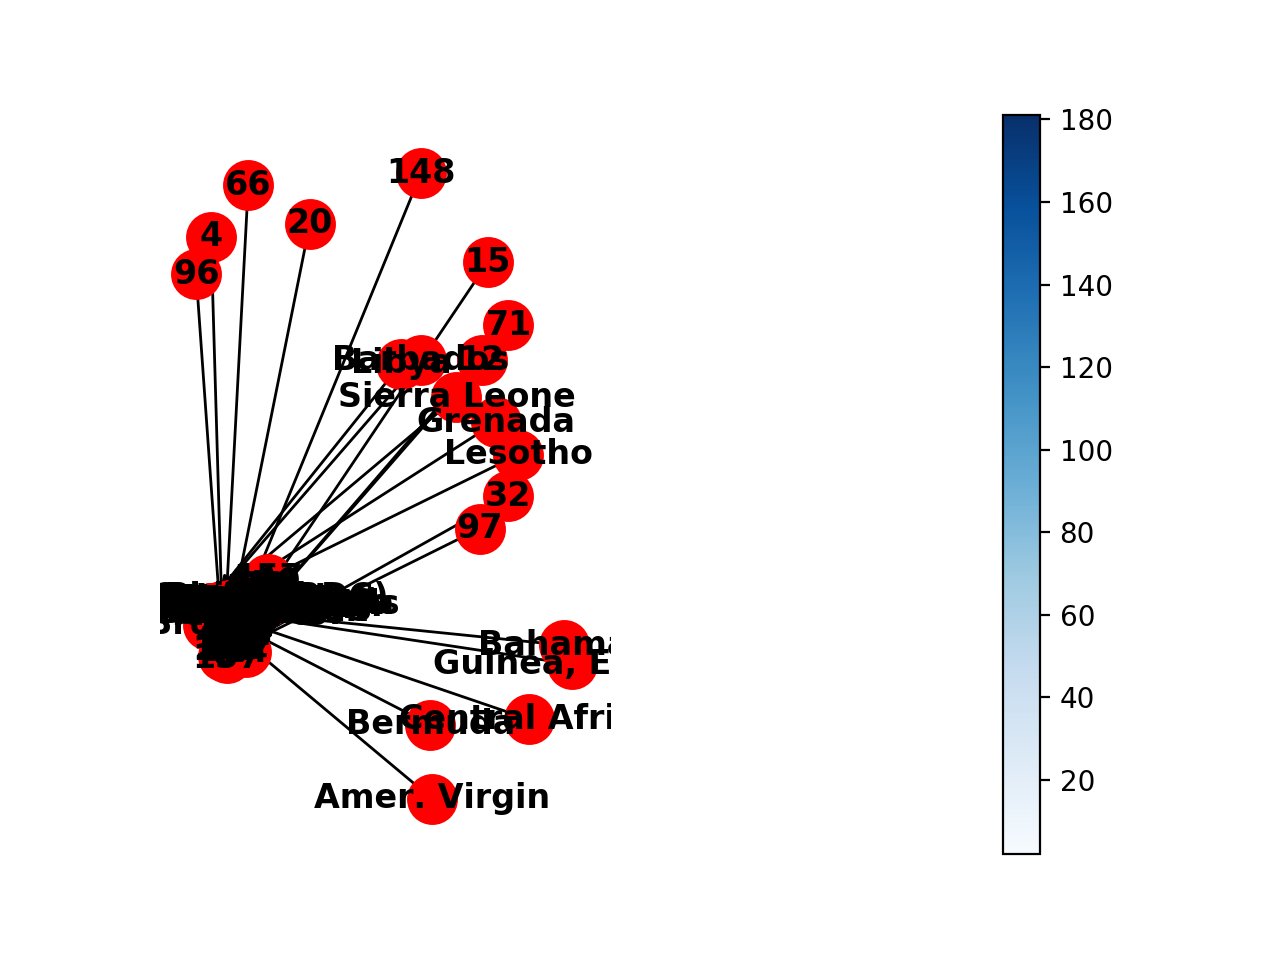

In [173]:
# Author: Rodrigo Dorantes-Gilardi (rodgdor@gmail.com)

from __future__ import division
import matplotlib as mpl, mpld3
import matplotlib.pyplot as plt
import networkx as nx

pos = nx.layout.spring_layout(DG)

node_sizes = [3 + 10 * i for i in range(len(DG))]
M = DG.number_of_edges()
edge_colors = range(2, M + 2)
edge_alphas = [(5 + i) / (M + 4) for i in range(M)]

nodes = nx.draw_networkx_nodes(DG, pos, node_size=node_sizes, node_color='blue')
edges = nx.draw_networkx_edges(DG, pos, node_size=node_sizes, arrowstyle='->',
                               arrowsize=10, edge_color=edge_colors,
                               edge_cmap=plt.cm.Blues, width=2)
# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(edge_colors)
plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
plt.show()

In [211]:
#Create a directed graph
#create a graph
DG = nx.DiGraph()
i = 1
DG.add_node(0, country='Switzerland', size=0)
for index, country in imports_partners_foodstuffs.iterrows():
    name = country.Country.lstrip()
    if math.isnan(country['Quantity (kg)']):
        DG.add_node(i, country=name, size=0)
        DG.add_edges_from([(i, 0, {'weight':0})])
    else:
        weight = country['Quantity (kg)']
        DG.add_node(i, country=name, size=weight)
        DG.add_edges_from([(i, 0, {'weight':weight})])
    i+=1

In [208]:
list(DG.nodes)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180]

In [194]:
DG.out_degree(1, weight='weight')

33.0

In [145]:
#create a plot
#generate positions for nodes
pos=nx.layout.spring_layout(DG)

In [196]:
DG.edges[(2, 0)]
pos['Switzerland'][0]

0.1311299165755414

In [138]:
#draw edges
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in DG.edges():
    x0, y0 = pos[edge[0]][0], pos[edge[0]][1]#DG.node[edge[0]]['pos']
    x1, y1 = pos[edge[1]][0], pos[edge[1]][1]#DG.node[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

for node in DG.nodes():
    x, y = pos[edge[0]][0], pos[edge[0]][1] #DG.node[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

In [147]:
for node, adjacencies in enumerate(DG.adjacency()):
    node_trace['marker']['color']+=tuple([len(adjacencies[1])])
    node_info = '# of connections: '+str(len(adjacencies[1]))
    node_trace['text']+=tuple([node_info])

In [197]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Imports',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plot.ly/ipython-notebooks/network-graphs/'> https://plot.ly/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

py.offline.plot(fig, filename='docs/img/plots/network_imports.html')

'file:///Users/bernasconi/Documents/EPFL/Applied Data Analysis/project/ADA-project/docs/img/plots/network_imports.html'

In [209]:
list(DG.adjacency())

[(0, {}),
 (1, {0: {'weight': 33.0}}),
 (2, {0: {'weight': 340019.0}}),
 (3, {0: {'weight': 89377.0}}),
 (4, {0: {'weight': 0}}),
 (5, {0: {'weight': 26419.0}}),
 (6, {0: {'weight': 253.0}}),
 (7, {0: {'weight': 5244106.0}}),
 (8, {0: {'weight': 109940.0}}),
 (9, {0: {'weight': 3183127.0}}),
 (10, {0: {'weight': 125277735.0}}),
 (11, {0: {'weight': 2576.0}}),
 (12, {0: {'weight': 0}}),
 (13, {0: {'weight': 281.0}}),
 (14, {0: {'weight': 280577.0}}),
 (15, {0: {'weight': 0}}),
 (16, {0: {'weight': 203997.0}}),
 (17, {0: {'weight': 37232250.0}}),
 (18, {0: {'weight': 9644.0}}),
 (19, {0: {'weight': 140872.0}}),
 (20, {0: {'weight': 0}}),
 (21, {0: {'weight': 159118.0}}),
 (22, {0: {'weight': 2355344.0}}),
 (23, {0: {'weight': 50646327.0}}),
 (24, {0: {'weight': 2.0}}),
 (25, {0: {'weight': 868906.0}}),
 (26, {0: {'weight': 244911.0}}),
 (27, {0: {'weight': 1008.0}}),
 (28, {0: {'weight': 652.0}}),
 (29, {0: {'weight': 491904.0}}),
 (30, {0: {'weight': 1494780.0}}),
 (31, {0: {'weight': 7

/anaconda3/envs/ada/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



<IPython.core.display.Javascript object>


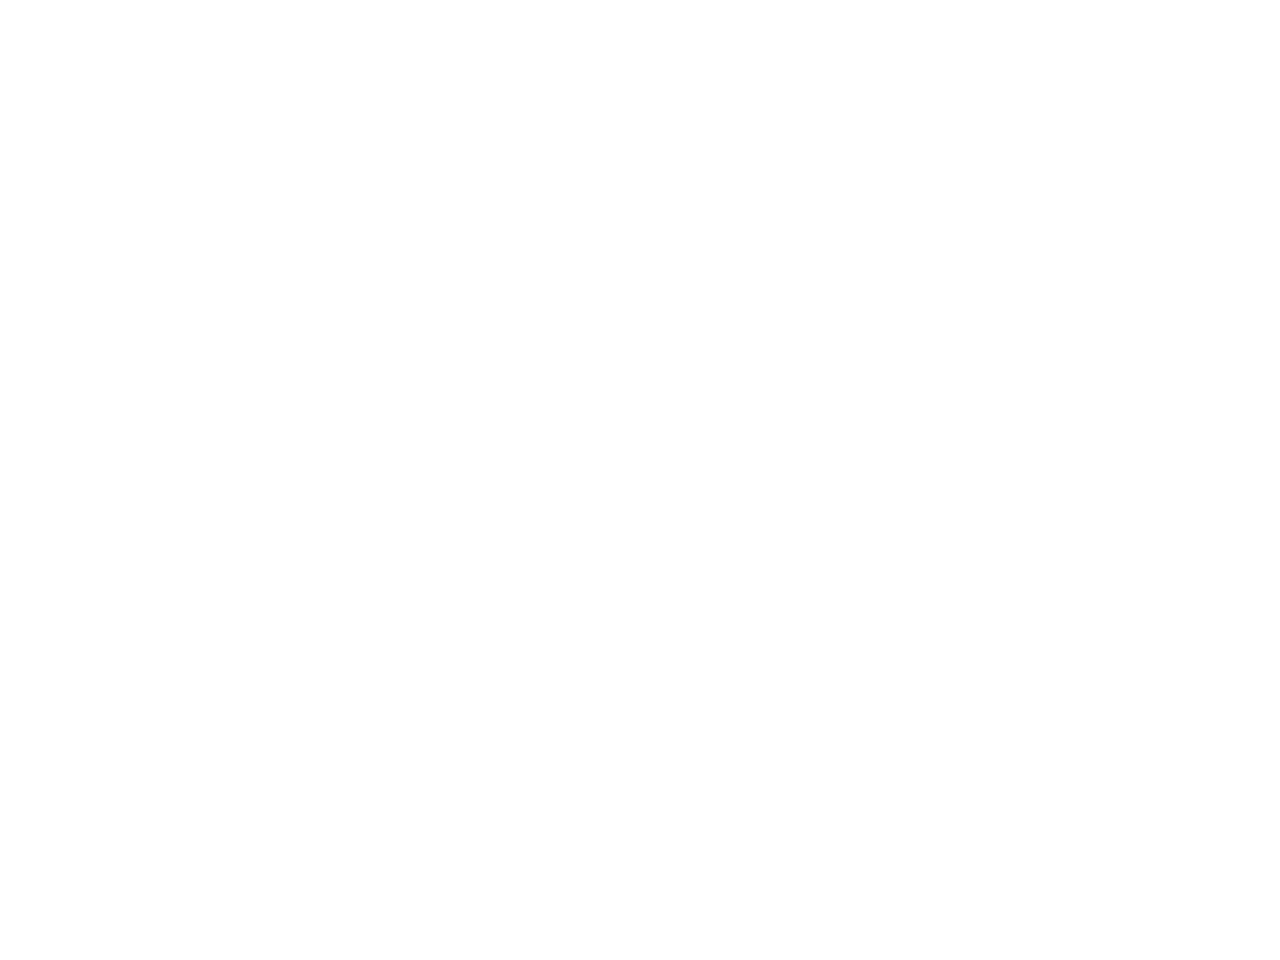

In [199]:
plt.subplot(121)
nx.draw(DG, with_labels=True, font_weight='bold')
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.show()

In [168]:
%matplotlib notebook

<IPython.core.display.Javascript object>


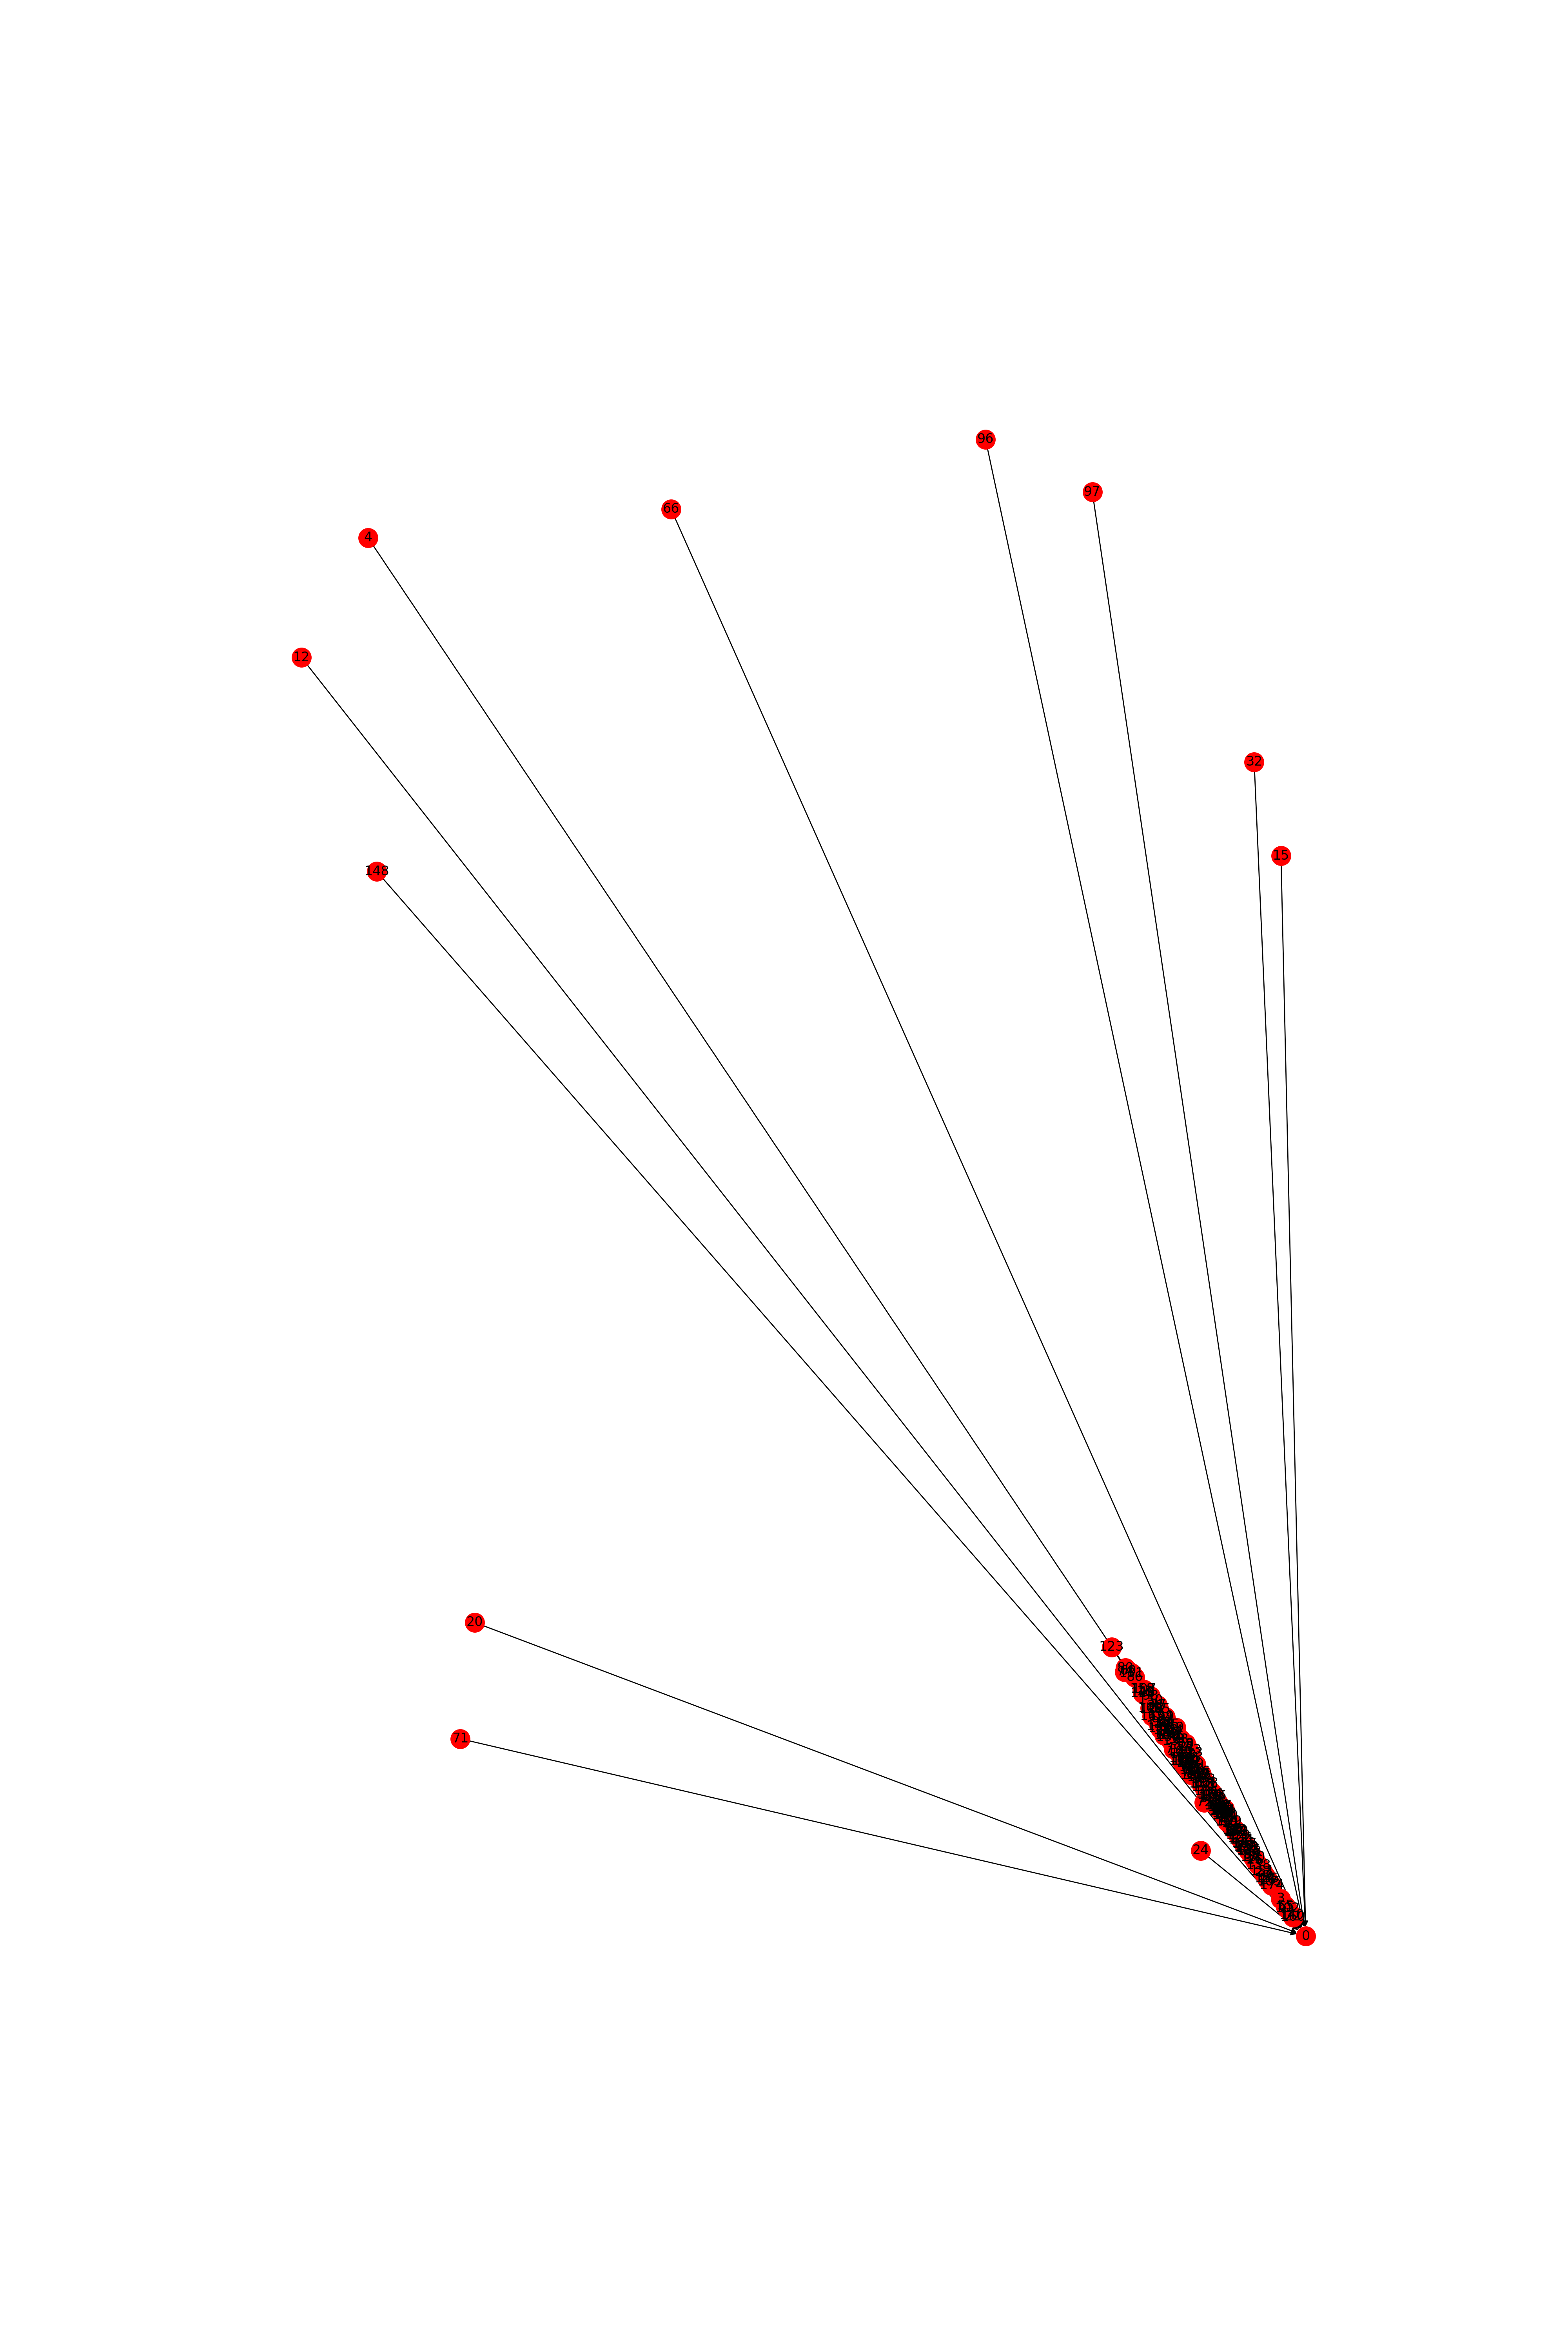

In [200]:
fig = plt.figure(figsize=(20, 30))
ax = fig.add_subplot(1, 1, 1)
nx.draw(DG, with_labels=True)
plt.show()
#mpld3.show()

In [161]:
import json
import flask
from networkx.readwrite import json_graph

In [212]:
for n in DG:
    DG.nodes[n]['name'] = n
# write json formatted data
d = json_graph.node_link_data(DG)  # node-link format to serialize
# write json
json.dump(d, open('force/force.json', 'w'))
print('Wrote node-link JSON data to force/force.json')

# Serve the file over http to allow for cross origin requests
app = flask.Flask(__name__, static_folder="force")

@app.route('/<path:path>')
def static_proxy(path):
    return app.send_static_file(path)

print('\nGo to http://localhost:8000/force.html to see the example\n')
app.run(port=8000)

Wrote node-link JSON data to force/force.json

Go to http://localhost:8000/force.html to see the example

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8000/ (Press CTRL+C to quit)


# Interactive map for openfood source dataset
Here we create interactive network maps for the main manufacturers from Switzerland and Europe

In [213]:
data = pd.read_csv("output/europe_manufacturers.csv") 

In [214]:
data

,manufacturing_places,Count
0,FR,45826
1,SP,7604
2,GM,4864
3,IT,4505
4,SZ,2672
5,UK,2428
6,BE,2416
7,NL,1059
8,SW,605
9,EU,599


In [215]:
#Create a directed graph
#create a graph
DG = nx.DiGraph()
i = 1
DG.add_node(0, country='CH', size=0)
for index, country in data.iterrows():
    name = country.manufacturing_places.lstrip()
    if math.isnan(country.Count):
        DG.add_node(i, country=name, size=0)
        DG.add_edges_from([(i, 0, {'weight':0})])
    else:
        weight = country.Count
        DG.add_node(i, country=name, size=weight)
        DG.add_edges_from([(i, 0, {'weight':weight})])
    i+=1

In [216]:
list(DG.adjacency())

[(0, {}),
 (1, {0: {'weight': 45826}}),
 (2, {0: {'weight': 7604}}),
 (3, {0: {'weight': 4864}}),
 (4, {0: {'weight': 4505}}),
 (5, {0: {'weight': 2672}}),
 (6, {0: {'weight': 2428}}),
 (7, {0: {'weight': 2416}}),
 (8, {0: {'weight': 1059}}),
 (9, {0: {'weight': 605}}),
 (10, {0: {'weight': 599}}),
 (11, {0: {'weight': 528}}),
 (12, {0: {'weight': 458}}),
 (13, {0: {'weight': 330}}),
 (14, {0: {'weight': 296}}),
 (15, {0: {'weight': 264}})]

In [218]:
for n in DG:
    DG.nodes[n]['name'] = n
# write json formatted data
d = json_graph.node_link_data(DG)  # node-link format to serialize
# write json
json.dump(d, open('docs/img/openfood_network/force.json', 'w'))
print('Wrote node-link JSON data to force/force.json')

# Serve the file over http to allow for cross origin requests
app = flask.Flask(__name__, static_folder="force")

@app.route('/<path:path>')
def static_proxy(path):
    return app.send_static_file(path)

print('\nGo to http://localhost:8000/force.html to see the example\n')
app.run(port=8000)

Wrote node-link JSON data to force/force.json

Go to http://localhost:8000/force.html to see the example

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8000/ (Press CTRL+C to quit)


In [220]:
data_ch = pd.read_csv("output/switzerland_manufacturers.csv") 

In [226]:
#Create a directed graph
#create a graph
DG = nx.DiGraph()
i = 0
for index, country in data_ch.iterrows():
    name = country.manufacturing_places.lstrip()
    if math.isnan(country.Count):
        DG.add_node(i, country=name, size=0)
        DG.add_edges_from([(i, 0, {'weight':0})])
    else:
        weight = country.Count
        DG.add_node(i, country=name, size=weight)
        DG.add_edges_from([(i, 0, {'weight':weight})])
    i+=1

In [227]:
for n in DG:
    DG.nodes[n]['name'] = n
# write json formatted data
d = json_graph.node_link_data(DG)  # node-link format to serialize
# write json
json.dump(d, open('docs/img/openfood_network_ch/force.json', 'w'))
print('Wrote node-link JSON data to force/force.json')

# Serve the file over http to allow for cross origin requests
app = flask.Flask(__name__, static_folder="force")

@app.route('/<path:path>')
def static_proxy(path):
    return app.send_static_file(path)

print('\nGo to http://localhost:8000/force.html to see the example\n')
app.run(port=8000)

Wrote node-link JSON data to force/force.json

Go to http://localhost:8000/force.html to see the example

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8000/ (Press CTRL+C to quit)
